<a href="https://www.kaggle.com/code/mkhizerali/writer-classification?scriptVersionId=115204028" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

In [1]:
import os
import cv2
import numpy as np
from tqdm import tqdm
from PIL import Image
import matplotlib.pyplot as plt
from sklearn.utils import shuffle
import seaborn as sns

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import BatchNormalization
from keras.layers import Input, Lambda, Dense, Flatten, Activation, Dropout
from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import RMSprop
from keras.callbacks import EarlyStopping, ReduceLROnPlateau
from keras import applications

In [2]:
train = list(os.walk('../input/writer-data/Final_dataset_patches2/train')) #gives the list of all directories and subdirectories

In [3]:
test = list(os.walk('../input/writer-data/Final_dataset_patches2/test')) #gives the list of all directories and subdirectories

In [4]:
label_names = train[0][1]
dict_labels = dict(zip(label_names, list(range(len(label_names)))))
dict_labels

{'Liebegott_A': 0,
 'Gysser_A': 1,
 'Kaltenbach_H': 2,
 'Monterosato': 3,
 'Parreyss_Ludwig': 4,
 'Schlickum_R': 5,
 'Naegele_G': 6,
 'Ehrmann_P': 7,
 'Jaeckel_S_H': 8,
 'Brandt_R': 9,
 'Reinhardt_O': 10,
 'Rolle_H': 11,
 'Jetschin': 12,
 'Pfeiffer_KL': 13,
 'Boettger_O': 14,
 'Benoit': 15,
 'Thinell': 16,
 'Haas_F': 17,
 'Boettger_C_R': 18,
 'Nordsieck_F': 19,
 'Kobelt_W': 20,
 'Moellendorff_E_von': 21}

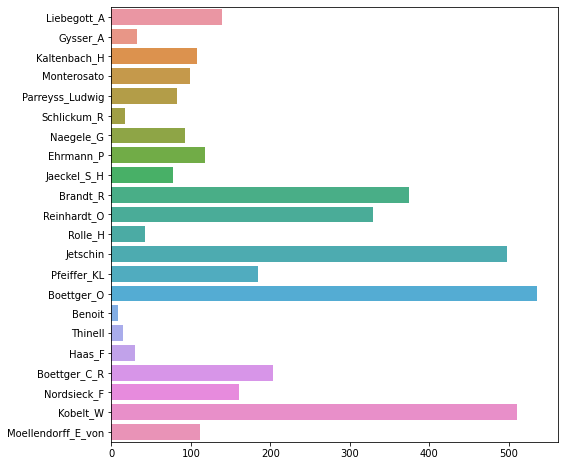

In [5]:
classes = train[0][1]
no_of_examples = []
for _ in range(1, 23):
    #print(len(train[_][-1]))
    #no_of_examples.append(len(train[_][0])) len(train[2][-1])
    no_of_examples.append(len(train[_][-1]))
plt.figure(figsize = (8, 8))
sns.barplot(y = classes, x = no_of_examples);

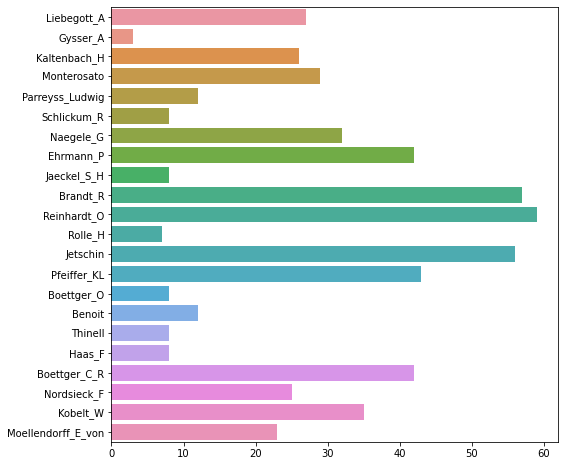

In [6]:
classes = train[0][1]
no_of_examples = []
for _ in range(1, 23):
    #print(len(train[_][-1]))
    #no_of_examples.append(len(train[_][0])) len(train[2][-1])
    no_of_examples.append(len(test[_][-1]))
plt.figure(figsize = (8, 8))
sns.barplot(y = classes, x = no_of_examples);

**Load images using ImageDatagenerator**

In [7]:
image_size = (224, 224)
batch_size = 64

#datagen = ImageDataGenerator(rescale = 1./255,horizontal_flip = True,vertical_flip = True)
train_datagen = ImageDataGenerator(rescale = 1./255,
                            shear_range = 0.2,
                            zoom_range = 0.2,
                            horizontal_flip = True,
                            vertical_flip = True,
                             validation_split = 0.2
                            )

train_ds =  train_datagen.flow_from_directory('../input/writer-data/Final_dataset_patches2/train',
                                      target_size = image_size,
                                      batch_size = batch_size,
                                      class_mode = 'categorical',
                                      subset = 'training',
                                      color_mode="grayscale",)

val_ds =  train_datagen.flow_from_directory('../input/writer-data/Final_dataset_patches2/train',
                                      target_size = image_size,
                                      batch_size = batch_size,
                                      subset = 'validation',
                                      class_mode = 'categorical',
                                      color_mode="grayscale")

test_datagen = ImageDataGenerator(rescale = 1./255)

test_ds =  test_datagen.flow_from_directory('../input/writer-data/Final_dataset_patches2/test',
                                      target_size = image_size,
                                      batch_size = 1,
                                      class_mode = 'categorical',  
                                            shuffle=False,
                                    color_mode="grayscale",)

Found 3023 images belonging to 22 classes.
Found 743 images belonging to 22 classes.
Found 570 images belonging to 22 classes.


In [8]:
class_dic  = train_ds.class_indices
print(class_dic )
class_names, idx = [list(x) for x in zip(*class_dic.items())]


{'Benoit': 0, 'Boettger_C_R': 1, 'Boettger_O': 2, 'Brandt_R': 3, 'Ehrmann_P': 4, 'Gysser_A': 5, 'Haas_F': 6, 'Jaeckel_S_H': 7, 'Jetschin': 8, 'Kaltenbach_H': 9, 'Kobelt_W': 10, 'Liebegott_A': 11, 'Moellendorff_E_von': 12, 'Monterosato': 13, 'Naegele_G': 14, 'Nordsieck_F': 15, 'Parreyss_Ludwig': 16, 'Pfeiffer_KL': 17, 'Reinhardt_O': 18, 'Rolle_H': 19, 'Schlickum_R': 20, 'Thinell': 21}


**Model**

In [9]:
# load VGG16, ensuring the head FC layer sets are left off, while at
# the same time adjusting the size of the input image tensor to the
# network
baseModel = keras.applications.VGG16(weights="imagenet", include_top=False,
	input_tensor=Input(shape=(224, 224, 3)))
for layer in baseModel.layers[:17]:
    layer.trainable = False
# Make sure you have frozen the correct layers
for i, layer in enumerate(baseModel.layers):
    print(i, layer.name, layer.trainable)

input_tensor1 = Input(shape=(224,224,1) )
x = keras.layers.Conv2D(3,(3,3),padding='same')(input_tensor1)
x = baseModel(x)
x=layers.Flatten()(x)
#x = keras.layers.GlobalAveragePooling2D()(x)
x= keras.layers.Dense(512)(x)
x=keras.layers.Dropout(0.3)(x)
x= keras.layers.Dense(256)(x)
x=keras.layers.Dropout(0.3)(x)
outputs = keras.layers.Dense(22, activation='softmax')(x)
model = keras.Model(input_tensor1, outputs)
# show a summary of the base model input_tensor = Input(shape=(128,128,1) )
print("[INFO] summary for base model...")
print(model.summary())

2023-01-01 07:47:12.100273: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-01-01 07:47:12.198246: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-01-01 07:47:12.199044: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-01-01 07:47:12.200883: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compil

58900480/58889256 [==============================] - 0s 0us/step
0 input_1 False
1 block1_conv1 False
2 block1_conv2 False
3 block1_pool False
4 block2_conv1 False
5 block2_conv2 False
6 block2_pool False
7 block3_conv1 False
8 block3_conv2 False
9 block3_conv3 False
10 block3_pool False
11 block4_conv1 False
12 block4_conv2 False
13 block4_conv3 False
14 block4_pool False
15 block5_conv1 False
16 block5_conv2 False
17 block5_conv3 True
18 block5_pool True
[INFO] summary for base model...
Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 224, 224, 1)]     0         
_________________________________________________________________
conv2d (Conv2D)              (None, 224, 224, 3)       30        
_________________________________________________________________
vgg16 (Functional)           (None, 7, 7, 512)         14714688  
_____________________________

**Training of the model**

In [10]:
model.compile(
    optimizer=keras.optimizers.Adam(),
    loss=keras.losses.CategoricalCrossentropy(from_logits=False),
    metrics=[keras.metrics.CategoricalAccuracy()],
    
)

epochs = 40
history=model.fit(train_ds, epochs=epochs, validation_data=val_ds)

2023-01-01 07:47:16.281025: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/40


2023-01-01 07:47:18.505785: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8005


48/48 [==============================] - 44s 639ms/step - loss: 4.1734 - categorical_accuracy: 0.2167 - val_loss: 2.1891 - val_categorical_accuracy: 0.3405
Epoch 2/40
48/48 [==============================] - 21s 426ms/step - loss: 1.9352 - categorical_accuracy: 0.4118 - val_loss: 2.1593 - val_categorical_accuracy: 0.3607
Epoch 3/40
48/48 [==============================] - 22s 446ms/step - loss: 1.7403 - categorical_accuracy: 0.4555 - val_loss: 2.1290 - val_categorical_accuracy: 0.4213
Epoch 4/40
48/48 [==============================] - 21s 438ms/step - loss: 1.6371 - categorical_accuracy: 0.4935 - val_loss: 1.9447 - val_categorical_accuracy: 0.4145
Epoch 5/40
48/48 [==============================] - 20s 433ms/step - loss: 1.5002 - categorical_accuracy: 0.5405 - val_loss: 1.9272 - val_categorical_accuracy: 0.4388
Epoch 6/40
48/48 [==============================] - 21s 428ms/step - loss: 1.4476 - categorical_accuracy: 0.5498 - val_loss: 2.0680 - val_categorical_accuracy: 0.4078
Epoch 7/4

In [11]:
model.save("my_model")

2023-01-01 08:02:32.861197: W tensorflow/python/util/util.cc:348] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.


**Training Evaluation**

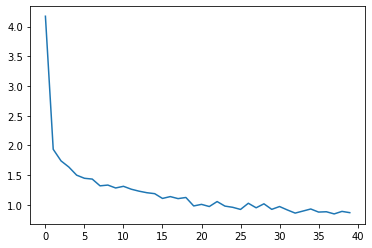

In [12]:
plt.plot(history.history['loss'])

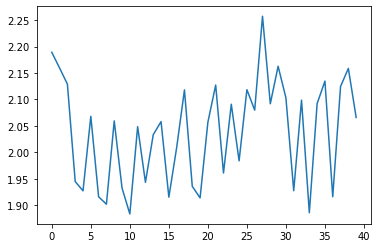

In [13]:
plt.plot(history.history['val_loss'])

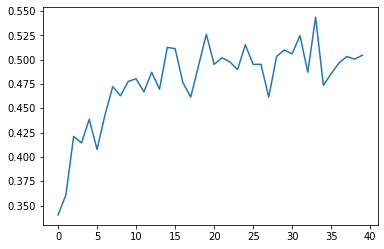

In [14]:
plt.plot(history.history['val_categorical_accuracy'])

**Performance of Test data**

In [15]:
filenames = test_ds.filenames
nb_samples = len(filenames)
predict = model.predict_generator(test_ds,steps = nb_samples)

/opt/conda/lib/python3.7/site-packages/keras/engine/training.py:2035: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


In [16]:
loss, acc = model.evaluate_generator(test_ds, steps=570, verbose=0,workers=1)
print(acc)

/opt/conda/lib/python3.7/site-packages/keras/engine/training.py:2006: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  warnings.warn('`Model.evaluate_generator` is deprecated and '


0.4333333373069763


**Classification Report on Test Data**

In [17]:
from sklearn.metrics import classification_report
true_labels = test_ds.classes
predictions = model.predict_generator(test_ds,steps = nb_samples)
q=[]
for i in range(0,570):
    n=np.argmax(predictions[i])
    q.append(n)
predict=(np.array([q])).reshape(570,)
score = predictions[0]
#predict=class_names[np.argmax(score)]
print(classification_report(true_labels, predict))

              precision    recall  f1-score   support

           0       0.00      0.00      0.00        12
           1       0.41      0.21      0.28        42
           2       0.09      0.75      0.16         8
           3       0.53      0.86      0.65        57
           4       0.72      0.31      0.43        42
           5       0.00      0.00      0.00         3
           6       0.00      0.00      0.00         8
           7       0.11      0.12      0.12         8
           8       0.30      0.38      0.34        56
           9       0.39      0.42      0.41        26
          10       0.21      0.46      0.29        35
          11       1.00      0.52      0.68        27
          12       0.90      0.39      0.55        23
          13       0.78      0.24      0.37        29
          14       0.53      0.31      0.39        32
          15       0.39      0.60      0.48        25
          16       0.33      0.08      0.13        12
          17       0.83    

/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


**Prediction on Test Data Patches**

In [18]:
img='../input/writer-data/Final_dataset_patches2/test/Brandt_R/Brandt_R_09-DPLinkNet34.tiff_cc.jpg_02_03.jpg'
img1 = cv2.imread(img,0)

img1 = img1.astype(float)/255
img_array = tf.expand_dims(img1, 0) # Create a batch
predictions = model.predict(img_array)
#score=np.argmax(to_categorical(predictions), axis = 1)
score = predictions[0]
print(
"This image most likely belongs to {} with a {:.2f} percent confidence."
        .format(class_names[np.argmax(score)], 100 * np.max(score)))

This image most likely belongs to Brandt_R with a 53.03 percent confidence.


**Testing Predictions on Complete Image**

In [19]:
pip install patchify

Note: you may need to restart the kernel to use updated packages.


In [20]:
import os
import matplotlib.pyplot as plt
import numpy as np
import cv2
import math
import seaborn as sns
from time import time
from PIL import Image
import glob
from patchify import patchify
from keras.preprocessing.image import ImageDataGenerator, img_to_array, load_img
from collections import Counter
import unittest

path="../input/writer-test-data/test_data/"

# name='Benoit_01-DPLinkNet34'
# img1 = cv2.imread(path+name+'.tiff_cc.jpg',0)

img_label=[]
pred_labels=[]
for filename in glob.iglob(path + '**/*.jpg', recursive=True):
    
    basename = os.path.basename(filename)
    label= (basename.split('-'))[0][:-3]
    img_label.append(label)
    print(basename)
    print(label)        
    
    
    

    try:
        img1 =cv2.imread(path+basename,0)
        
        img1 = img1.astype(float) / 255
        patches_img = patchify(img1, (448, 448), step=400)
        img_predict=[]      ############
        #patches_img=cv2.resize(patches_img,(224,224))
        for i in range(patches_img.shape[0]):
            for j in range(patches_img.shape[1]):
                single_patch_img = patches_img[i, j, :, :]
                z=np.count_nonzero(single_patch_img==0)
                if z/112896>0.10:
                    single_patch_img=cv2.resize(single_patch_img,(224,224))   
                    img_array = tf.keras.utils.img_to_array(single_patch_img)
                    img_array = tf.expand_dims(img_array, 0) # Create a batch
                    predictions = model.predict(img_array)
                    score = (predictions[0])
                    img_predict.append(class_names[np.argmax(score)])    ###########
                    
                    
                #print(img_predict)
                #score=np.argmax(to_categorical(predictions), axis = 1)

                    print(
                    "This image most likely belongs to {} with a {:.2f} percent confidence."
                            .format(class_names[np.argmax(score)], 100 * np.max(score))

                      )

        pred_Counter = Counter(img_predict)

        most_occur = pred_Counter.most_common(1)

        print("This image most likely from {} class".format(most_occur))
        pred_label,_=most_occur[0]
        
        print(pred_label)
        pred_labels.append(pred_label)
        
    except:
        pass
               # if patches_img[i,j,:,:].all()==0:
                #cv2.rectangle(single_patch_img, (30, 30), (224-30, 224-30), (0, 255, 0), 3)  # Draw something (for testing).
                    

    
# Store an unpatchified reference for testing
#cv2.imwrite("unpatched_ref.jpg", unpatchify(patches_img, img.shape))


Boettger_O_41-DPLinkNet34.tiff_cc.jpg
Boettger_O
This image most likely belongs to Boettger_O with a 99.30 percent confidence.
This image most likely belongs to Boettger_O with a 97.22 percent confidence.
This image most likely belongs to Boettger_O with a 42.38 percent confidence.
This image most likely belongs to Boettger_O with a 99.70 percent confidence.
This image most likely belongs to Boettger_O with a 95.12 percent confidence.
This image most likely from [('Boettger_O', 5)] class
Boettger_O
Ehrmann_P_03-DPLinkNet34.tiff_cc.jpg
Ehrmann_P
This image most likely belongs to Boettger_O with a 69.12 percent confidence.
This image most likely belongs to Ehrmann_P with a 97.78 percent confidence.
This image most likely belongs to Ehrmann_P with a 99.53 percent confidence.
This image most likely belongs to Ehrmann_P with a 99.97 percent confidence.
This image most likely from [('Ehrmann_P', 3)] class
Ehrmann_P
Schlickum_R_08-DPLinkNet34.tiff_cc.jpg
Schlickum_R
This image most likely bel

In [21]:
from sklearn import preprocessing
from sklearn.metrics import classification_report

le = preprocessing.LabelEncoder()
le.fit(img_label)
list(le.classes_)
labels=le.transform(img_label)
pred=le.transform(pred_labels)
print(classification_report(labels, pred))

              precision    recall  f1-score   support

           0       0.00      0.00      0.00         2
           1       0.50      0.25      0.33         4
           2       0.09      1.00      0.17         1
           3       0.50      0.75      0.60         4
           4       1.00      0.67      0.80         6
           5       0.00      0.00      0.00         1
           6       0.00      0.00      0.00         1
           7       0.00      0.00      0.00         1
           8       0.09      0.17      0.12         6
           9       0.67      1.00      0.80         2
          10       0.22      0.50      0.31         4
          11       1.00      0.80      0.89         5
          12       1.00      0.33      0.50         6
          13       0.50      0.40      0.44         5
          14       0.50      0.50      0.50         4
          15       0.00      0.00      0.00         4
          16       0.00      0.00      0.00         1
          17       0.60    

/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [22]:
from sklearn.metrics import accuracy_score
accuracy_score(labels, pred)

0.4444444444444444

In [23]:
labels

array([ 2,  4, 20,  3,  1, 12, 18, 18,  5,  4, 18, 11, 11,  4, 17, 14, 13,
       12, 12,  9, 15, 16,  1,  0, 12,  3,  0,  8, 11, 10, 11,  8, 18, 14,
        3, 15, 18,  4, 10,  6, 10,  1,  8, 12, 11, 19,  4, 14, 13, 15, 13,
        7, 18, 10, 21,  3,  8, 13, 17, 13, 20,  1, 12,  8,  8, 14, 18,  4,
       17,  9, 15, 18])

In [24]:
pred

array([ 2,  4, 14,  3,  8, 10, 18,  8,  2,  4, 18, 14, 11,  2, 17, 14,  2,
       10, 12,  9, 18, 17,  3, 10, 12, 17, 18,  2, 11, 10, 11, 10, 18,  3,
        3, 10, 10,  8,  2,  2, 10,  1,  2, 13, 11, 19,  4, 10,  2,  8,  8,
        9,  8,  3,  8,  3, 13, 13, 17, 13,  2,  8,  1,  8,  2, 14, 18,  4,
       17,  9,  8,  8])